In [1]:
import csv
import re
import json
import ast
import pandas as pd

In [2]:
csv_file="brun_marron.csv"

In [78]:
data = pd.read_csv(csv_file,delimiter='\t')
# print(data.info)
# mettre comme index les panelistes
data=data.set_index("CASE")

<bound method DataFrame.info of      CASE  SERIAL  REF QUESTNNR       MODE              STARTED  PI06  PI01  \
0      52     NaN  NaN     base  interview  18/02/2021 08:26:32     1   3.0   
1      54     NaN  NaN     base  interview  18/02/2021 08:29:26     1   3.0   
2      55     NaN  NaN     base  interview  18/02/2021 08:30:42     1   4.0   
3      61     NaN  NaN     base  interview  18/02/2021 08:57:24     1   4.0   
4      63     NaN  NaN     base  interview  18/02/2021 08:59:29     1   4.0   
..    ...     ...  ...      ...        ...                  ...   ...   ...   
223   501     NaN  NaN     base  interview  06/03/2021 16:28:06     1   4.0   
224   504     NaN  NaN     base  interview  08/03/2021 21:38:03     1   5.0   
225   507     NaN  NaN     base  interview  10/03/2021 18:29:43     1   3.0   
226   509     NaN  NaN     base  interview  11/03/2021 20:08:12     1   5.0   
227   510     NaN  NaN     base  interview  11/03/2021 20:17:59     1   5.0   

     PI02  PI03  ..

In [4]:
data.head()

,SERIAL,REF,QUESTNNR,MODE,STARTED,PI06,PI01,PI02,PI03,PI04_01,...,LASTDATA,FINISHED,Q_VIEWER,LASTPAGE,MAXPAGE,MISSING,MISSREL,TIME_RSI,DEG_TIME,commentaires
CASE,,,,,,,,,,,,,,,,,,,,,
52,NaN,NaN,base,interview,18/02/2021 08:26:32,1,3.0,1.0,4.0,Espagnol,...,18/02/2021 08:27:38,0,0,3,3,0,0,0.76,0,NaN
54,NaN,NaN,base,interview,18/02/2021 08:29:26,1,3.0,1.0,4.0,Espagnol,...,18/02/2021 08:45:31,1,0,18,18,23,13,1.11,19,NaN
55,NaN,NaN,base,interview,18/02/2021 08:30:42,1,4.0,2.0,1.0,NaN,...,18/02/2021 08:40:40,1,0,18,18,23,12,1.25,18,NaN
61,NaN,NaN,base,interview,18/02/2021 08:57:24,1,4.0,2.0,1.0,NaN,...,18/02/2021 09:01:40,1,0,18,18,32,20,2.18,78,NaN
63,NaN,NaN,base,interview,18/02/2021 08:59:29,1,4.0,1.0,1.0,NaN,...,18/02/2021 09:02:54,0,0,4,4,0,0,0.95,10,NaN


Visualiser / récuperer le nom des colonnes :

In [5]:
data.columns

Index(['SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 'PI06', 'PI01', 'PI02',
       'PI03', 'PI04_01',
       ...
       'LASTDATA', 'FINISHED', 'Q_VIEWER', 'LASTPAGE', 'MAXPAGE', 'MISSING',
       'MISSREL', 'TIME_RSI', 'DEG_TIME', 'commentaires'],
      dtype='object', length=173)

# création de dictionnaires 

Créer des dictionnaires pour nettoyer / homogénéiser les données du tableau

> python myDico.py

En sortie des dictionnaire *.p sont créés, et peuvent être appelés dans ce script.

In [61]:
import pickle
myDicoLemmatisationColors=pickle.load(open("myDicoLemmatisationColors.p","rb"))
#print(myDicoLemmatisationColors)

# Les couleurs énoncées par le panel :

Il s'agit des colonnes nommées : CO01x01 ... CO01x25

(mais beaucoup de panélistes arrêtent vers 12 / 13 couleurs citées)

questionnaire : "Écrivez ci-dessous les noms des couleurs principales en français :"

- isoler les colonnes concernées

In [7]:
# exemple : voir contenu d'une colonne
#data['CO01x01']

#créer un sous-dataframe des colonnes concernées
myColColors=list()

for i in range(1,25):
    if i<10:
        colColor=str('CO01x0')+str(i)
    else:
        colColor='CO01x'+str(i)
    myColColors.append(colColor)

#Créer un sous tableau ne contenant que ces colonnes
dataColors = data.loc[:,myColColors]

#tout mettre en minuscule
dataColors = dataColors.applymap(lambda s:s.lower() if type(s) == str else s)
print(dataColors)

     CO01x01 CO01x02 CO01x03 CO01x04 CO01x05 CO01x06 CO01x07 CO01x08 CO01x09  \
CASE                                                                           
52       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
54     rouge   jaune    bleu    vert    noir   blanc    gris  marron    rose   
55      bleu   rouge    vert   jaune  orange  violet   blanc    gris    noir   
61      bleu   blanc   rouge   jaune    vert   rouge     NaN     NaN     NaN   
63     rouge   jaune    bleu    vert  violet    rose  orange   blanc    noir   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
501     bleu   rouge    vert   jaune   blanc    noir     NaN     NaN     NaN   
504     bleu   rouge   jaune    noir   blanc    vert  orange  violet  marron   
507    rouge   jaune    bleu   blanc    noir    vert     NaN     NaN     NaN   
509    rouge    bleu   jaune     NaN     NaN     NaN     NaN     NaN     NaN   
510    rouge    bleu   jaune     NaN    

- compter les couleurs

In [8]:
#compter les couleurs (METHODE 1)
myDicColors=dict()
# valeurs absolue
for colColor in myColColors:
    # compter les couleurs dans chaque colonne
    tempDic=dataColors[colColor].value_counts().to_dict()
    for key, value in tempDic.items():
        #corriger/lemmatiser les couleurs données
        key=re.sub(r' $','',key)
        if key in myDicoLemmatisationColors:
            key = myDicoLemmatisationColors[key]
        if key in myDicColors:
            myDicColors[key]=value+myDicColors[key]
        else:
            myDicColors[key]=value

#print(myDicColors)
myDfColors = pd.DataFrame(list(myDicColors.items()),columns=['colors', 'number'])
print(myDfColors)

          colors  number
0          rouge     205
1           bleu     198
2          jaune     192
3          blanc     158
4           noir     152
..           ...     ...
68         olive       2
69      pistache       1
70  gris (modif)       1
71         chair       1
72          jade       1

[73 rows x 2 columns]


In [9]:
#valeur relative (METHODE 1)
dfpc = round((myDfColors['number'] / myDfColors['number'].sum()*100),2)
#concatener les tableaux valeur absolue et valeur relative
dfGlobal = pd.concat([myDfColors, dfpc], axis=1)
#nommer la 3eme colonne 'percent'
dfGlobal.set_axis(['colors','number','percent'],axis='columns', inplace=True)
dfGlobal_sort = dfGlobal.sort_values(by = 'colors', ascending = True)
#dfGlobal_sort = dfGlobal.sort_values(by = 'percent', ascending = False)
print(dfGlobal_sort)

          colors  number  percent
9          blanc       1     0.05
46           Nan       1     0.05
57        acajou       1     0.05
41    anthracite       1     0.05
50        argent       4     0.20
..           ...     ...      ...
5           vert     188     9.54
13  vert (modif)       9     0.46
8         violet     151     7.66
61          écru       1     0.05
38      émeraude       4     0.20

[73 rows x 3 columns]


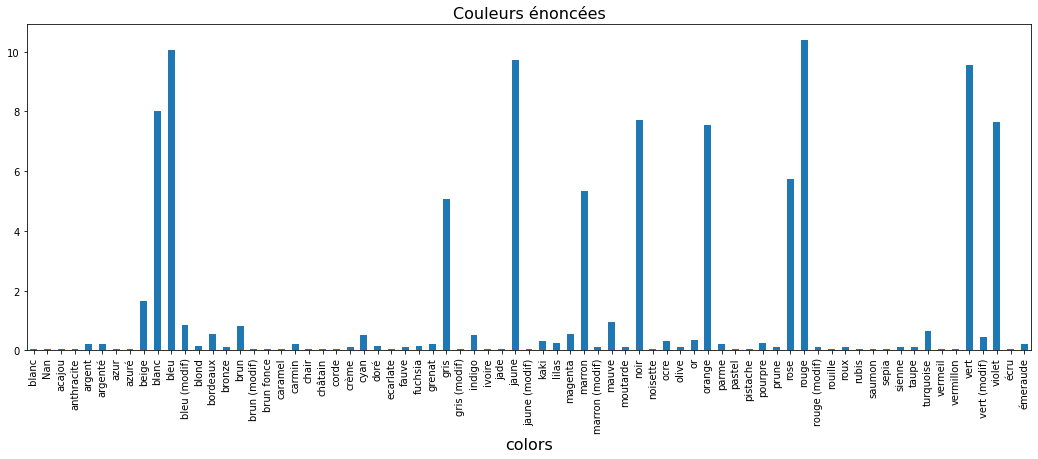

In [10]:
dep = pd.DataFrame(dfGlobal_sort,columns=["colors","percent"])
ax = dep.plot(x="colors",kind = "bar", figsize=(18,6))
ax.set_xlabel("colors", fontsize=16)
ax.set_title("Couleurs énoncées", fontsize=16)
ax.legend().set_visible(False)  # on supprime la légende

# on change la taille de police de certains labels
#for i,tick in enumerate(ax.xaxis.get_major_ticks()):
#    if i > 10 :
#        tick.label.set_fontsize(8)

- isoler les colonnes concernées + garder le répondant

In [11]:
for i, l in dfGlobal_sort.iterrows():
    if l["colors"]=="marron":
        print(l)
    elif l["colors"]=="brun":
        print(l)

colors     brun
number       16
percent    0.81
Name: 17, dtype: object
colors     marron
number        105
percent      5.33
Name: 11, dtype: object


# MARRON & BRUN

Questionnaire : "Écrivez une liste de choses (êtres, objets,...) qu'on pourrait décrire proprement comme étant MARRON / BRUN:"

In [12]:
loupColor=["brun","marron"]
print ("Panélistes qui ont cité brun et/ou marron ::")
dicCase=dict()
dicPaneliste=dict()

for loup in loupColor:
    dicCase[loup]=list()  
    for colColor in myColColors:
        lg = len(dataColors.index[dataColors[colColor] == loup].tolist())
        #print(lg)
        #colonne du df où je trouve la couleur "brun"
        #print(dataColors.index[dataColors[colColor] == "brun"])
        #print(dataColors.index[dataColors[colColor] == "brun"].tolist())
        if lg > 0:
            for i in range(0, lg):
                dicCase[loup].append(dataColors.index[dataColors[colColor] == loup].tolist()[i])
                
                tempDuo=list()
                tempDuo.append(loup)
                tempDuo.append(colColor)
                
                if dataColors.index[dataColors[colColor] == loup].tolist()[i] in dicPaneliste:
                    dicPaneliste[dataColors.index[dataColors[colColor] == loup].tolist()[i]].append(tempDuo)
                else:
                    dicPaneliste[dataColors.index[dataColors[colColor] == loup].tolist()[i]]=list()
                    dicPaneliste[dataColors.index[dataColors[colColor] == loup].tolist()[i]].append(tempDuo)

#print(dicCase)
#print(dicPaneliste)

Panélistes qui ont cité brun et/ou marron ::


In [13]:
# groupe de panélistes...
list_justBrun=list()
list_justMarron=list()
list_2colors=list()
list_2colorsOrder=list()
for k, v in dicCase.items():
    if k == "brun":
        for i in range(0, len(v)):
            if v[i] in dicCase["marron"]:
                
                list_2colors.append(v[i])
                # print(dicPaneliste[v[i]][0][1])
                # myPlace=re.sub("^.+x0?","",dicPaneliste[v[i]][0][1])
                # brun en premier
                if int(re.sub("^.+x0?","",dicPaneliste[v[i]][0][1])) < int(re.sub("^.+x0?","",dicPaneliste[v[i]][1][1])):
                    myOrder = "brun-marron"
                else:
                    myOrder = "marron-brun"
                    
                list_2colorsOrder.append(str(v[i])+" ("+str(myOrder)+")")
                
            elif v[i] not in dicCase["marron"]:
                list_justBrun.append(v[i])
    elif k == "marron":
        for i in range(0, len(v)):
            if v[i] not in dicCase["brun"]:
                list_justMarron.append(v[i])
                
print("\npanélistes qui ont cité que le marron :")
print(list_justMarron)

print("\npanélistes qui ont cité que le brun :")
print(list_justBrun)

print("\npanélistes qui ont cité les 2 couleurs :")
print(list_2colors)
print(list_2colorsOrder)


panélistes qui ont cité que le marron :
[375, 189, 325, 374, 422, 79, 99, 104, 106, 135, 140, 186, 208, 222, 259, 316, 354, 359, 370, 415, 416, 487, 75, 136, 141, 169, 220, 242, 278, 298, 306, 314, 319, 323, 347, 400, 409, 428, 430, 464, 495, 54, 80, 197, 218, 282, 333, 357, 361, 368, 373, 410, 427, 440, 475, 500, 68, 72, 198, 216, 292, 335, 367, 384, 389, 390, 394, 426, 504, 95, 150, 178, 215, 280, 283, 287, 312, 327, 355, 363, 408, 468, 115, 310, 414, 132, 175, 116]

panélistes qui ont cité que le brun :
[133, 466, 497, 103, 219, 77, 250, 413, 284]

panélistes qui ont cité les 2 couleurs :
[496, 277, 406, 304, 417, 63, 474]
['496 (marron-brun)', '277 (brun-marron)', '406 (brun-marron)', '304 (marron-brun)', '417 (marron-brun)', '63 (marron-brun)', '474 (marron-brun)']


# MARRON

colonnes LI01x01 à LI01x15

In [14]:
#créer un sous-dataframe des colonnes concernées
myColObjMarron=list()

for i in range(1,15):
    if i<10:
        colObjMarron=str('LI01x0')+str(i)
    else:
        colObjMarron='LI01x'+str(i)
    myColObjMarron.append(colObjMarron)

#Créer un sous tableau ne contenant que ces colonnes
dataObjMarron = data.loc[:,myColObjMarron]

#tout mettre en minuscule
dataObjMarron = dataObjMarron.applymap(lambda s:s.lower() if type(s) == str else s)
print(dataObjMarron)

            LI01x01           LI01x02           LI01x03        LI01x04  \
CASE                                                                     
52              NaN               NaN               NaN            NaN   
54             bois            selles              boue         amande   
55        un marron       des cheveux     une châtaigne  un iris d'œil   
61        un marron           du bois               NaN            NaN   
63              NaN               NaN               NaN            NaN   
...             ...               ...               ...            ...   
501         marrons          chocolat            avocat       peinture   
504           terre     marron d'inde             arbre        feuille   
507            bois            argile               NaN            NaN   
509   marron glacé   marron châtaigne               NaN            NaN   
510   marron glacé    les yeux marron  marron châtaigne            NaN   

           LI01x05           LI01x06 

- lister et compter les objets marron :

In [35]:
#compter les objets marrons
myDicObjMarron=dict()
# valeurs absolue
for colObjMarron in myColObjMarron:
    # compter les couleurs dans chaque colonne
    tempDic=dataObjMarron[colObjMarron].value_counts().to_dict()
    
    for key, value in tempDic.items():
            
        if key in myDicObjMarron:
            myDicObjMarron[key]=value+myDicObjMarron[key]
        else:
            myDicObjMarron[key]=value

myDfObjMarron = pd.DataFrame(list(myDicObjMarron.items()),columns=['objMarron', 'number'])
print(myDfObjMarron)
myDfObjMarron.to_csv("objMarron.csv", sep = '\t', index = False)

     objMarron  number
0         bois      80
1        terre      62
2       marron      26
3    châtaigne      19
4     chocolat      48
..         ...     ...
325   eau sale       1
326      crème       1
327     flacon       1
328     bottes       1
329    gateaux       1

[330 rows x 2 columns]


In [37]:
#compter les objets marron après nettoyage
with open('objMarron_nett.csv', mode='r') as infile:
    reader = csv.reader(infile)
    # mettre comme index les panelistes
    myNettObjMarron = dict((rows[0],rows[1]) for rows in reader)
#print(myNettObjMarron)

#compter les objets marrons
myDicObjMarron=dict()

# valeurs absolue
for colObjMarron in myColObjMarron:
    # compter les couleurs dans chaque colonne
    tempDic=dataObjMarron[colObjMarron].value_counts().to_dict()
        
    for key, value in tempDic.items():
        #corriger/lemmatiser les ojets
        if key in myNettObjMarron:
            key = myNettObjMarron[key]
            
        if key in myDicObjMarron:
            myDicObjMarron[key]=value+myDicObjMarron[key]
        else:
            myDicObjMarron[key]=value

            # créer un texte "objets marron"

myDfObjMarron = pd.DataFrame(list(myDicObjMarron.items()),columns=['objMarron', 'number'])
print(myDfObjMarron)

         objMarron  number
0             bois     100
1            terre      77
2           marron      45
3        châtaigne      53
4         chocolat      67
..             ...     ...
148  fleurs fanées       1
149  pomme pourrie       1
150       eau sale       1
151         flacon       1
152         bottes       1

[153 rows x 2 columns]


In [44]:
#valeur relative (METHODE 1)
dfpc = round((myDfColors['number'] / myDfColors['number'].sum()*100),2)
#concatener les tableaux valeur absolue et valeur relative
dfGlobal = pd.concat([myDfObjMarron, dfpc], axis=1)
#nommer la 3eme colonne 'percent'
dfGlobal.set_axis(['colors','number','percent'],axis='columns', inplace=True)
dfGlobal_sort = dfGlobal.sort_values(by = 'colors', ascending = True)
#dfGlobal_sort = dfGlobal.sort_values(by = 'percent', ascending = False)
print(dfGlobal_sort)

       colors  number  percent
88     amande       1      NaN
50     animal       2     0.20
6       arbre      15     5.73
40     argile       1     0.05
126   automne       1      NaN
..        ...     ...      ...
56   vêtement       9     0.05
5        yeux      41     9.54
18     écorce      10     0.05
60   écureuil       2     0.05
147      étui       1      NaN

[153 rows x 3 columns]


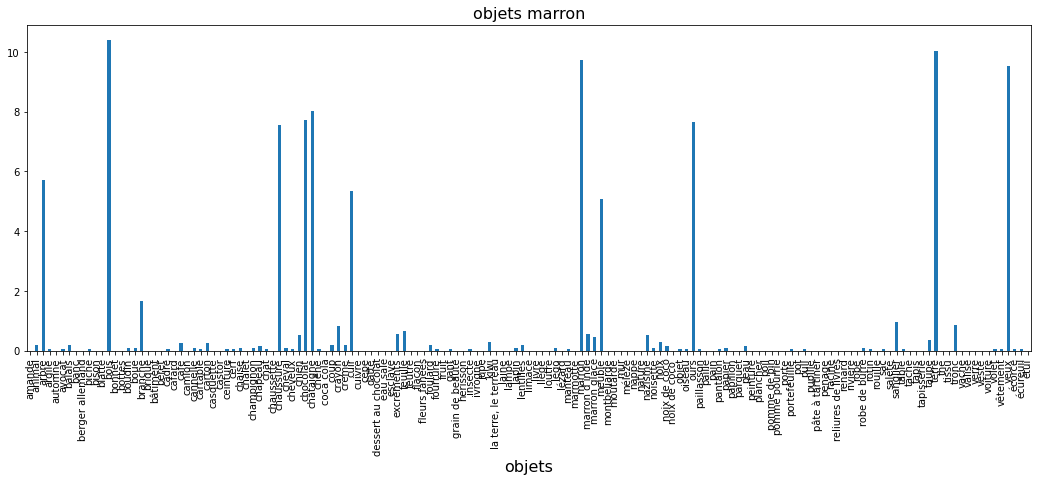

In [45]:
dep = pd.DataFrame(dfGlobal_sort,columns=["colors","percent"])
ax = dep.plot(x="colors",kind = "bar", figsize=(18,6))
ax.set_xlabel("objets", fontsize=16)
ax.set_title("objets marron", fontsize=16)
ax.legend().set_visible(False)  # on supprime la légende

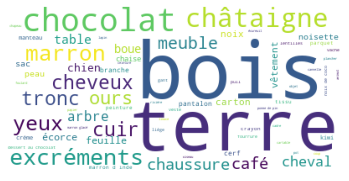

In [56]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tuples = [tuple(x) for x in myDfObjMarron.values]

#generate
tuples = [tuple(x) for x in myDfObjMarron.values]
wordcloud=WordCloud(background_color="white").generate_from_frequencies(dict(tuples))
# show
plt.figure()
# bilinear = tenir compte de ses 2 proches voisins
plt.imshow(wordcloud, interpolation="bilinear")
#plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# BRUN

colonnes LI02x01 à LI02x15

In [41]:
#créer un sous-dataframe des colonnes concernées
myColObjBrun=list()

for i in range(1,15):
    if i<10:
        colObjBrun=str('LI02x0')+str(i)
    else:
        colObjBrun='LI02x'+str(i)
    myColObjBrun.append(colObjBrun)

#Créer un sous tableau ne contenant que ces colonnes
dataObjBrun = data.loc[:,myColObjBrun]

#tout mettre en minuscule
dataObjBrun = dataObjBrun.applymap(lambda s:s.lower() if type(s) == str else s)
print(dataObjBrun)

                LI02x01          LI02x02  LI02x03 LI02x04 LI02x05 LI02x06  \
CASE                                                                        
52                  NaN              NaN      NaN     NaN     NaN     NaN   
54                homme           garçon  cheveux    poil   barbe     NaN   
55              un ours      des cheveux      NaN     NaN     NaN     NaN   
61          des cheveux              NaN      NaN     NaN     NaN     NaN   
63                  NaN              NaN      NaN     NaN     NaN     NaN   
...                 ...              ...      ...     ...     ...     ...   
501             cheveux             bois   tissus    yeux    peau    nuit   
504             cheveux  petit ours ....      NaN     NaN     NaN     NaN   
507                bois          cheveux      NaN     NaN     NaN     NaN   
509       cheveux bruns              NaN      NaN     NaN     NaN     NaN   
510   les cheveux bruns              NaN      NaN     NaN     NaN     NaN   

In [42]:
#compter les objets marrons
myDicObjBrun=dict()
# valeurs absolue
for colObjBrun in myColObjBrun:
    # compter les couleurs dans chaque colonne
    tempDic=dataObjBrun[colObjBrun].value_counts().to_dict()
    
    for key, value in tempDic.items():
            
        if key in myDicObjBrun:
            myDicObjBrun[key]=value+myDicObjBrun[key]
        else:
            myDicObjBrun[key]=value

myDfObjBrun = pd.DataFrame(list(myDicObjBrun.items()),columns=['objBrun', 'number'])
print(myDfObjBrun)
myDfObjBrun.to_csv("objBrun.csv", sep = '\t', index = False)

           objBrun  number
0          cheveux     105
1             ours      53
2         cheveux       12
3           cheveu       5
4             yeux      29
..             ...     ...
201         crotte       1
202         volets       1
203  peau meurtrie       1
204          lampe       1
205          singe       1

[206 rows x 2 columns]


In [43]:
#compter les objets marron après nettoyage
with open('objBrun_nett.csv', mode='r') as infile:
    reader = csv.reader(infile)
    # mettre comme index les panelistes
    myNettObjBrun = dict((rows[0],rows[1]) for rows in reader)

#compter les objets brun
myDicObjBrun=dict()
# valeurs absolue
for colObjBrun in myColObjBrun:
    # compter les couleurs dans chaque colonne
    tempDic=dataObjBrun[colObjBrun].value_counts().to_dict()
    
    for key, value in tempDic.items():
        #corriger/lemmatiser les ojets
        if key in myNettObjBrun:
            key = myNettObjBrun[key]
            
        if key in myDicObjBrun:
            myDicObjBrun[key]=value+myDicObjBrun[key]
        else:
            myDicObjBrun[key]=value

myDfObjBrun = pd.DataFrame(list(myDicObjBrun.items()),columns=['objBrun', 'number'])
print(myDfObjBrun)

      objBrun  number
0     cheveux     136
1        ours      67
2        yeux      34
3        bois      21
4       homme       4
..        ...     ...
113   couteau       1
114  marmotte       1
115     volet       1
116     lampe       1
117     singe       1

[118 rows x 2 columns]


In [47]:
#valeur relative (METHODE 1)
dfpc = round((myDfObjBrun['number'] / myDfObjBrun['number'].sum()*100),2)
#concatener les tableaux valeur absolue et valeur relative
dfGlobal = pd.concat([myDfObjBrun, dfpc], axis=1)
#nommer la 3eme colonne 'percent'
dfGlobal.set_axis(['colors','number','percent'],axis='columns', inplace=True)
dfGlobal_sort = dfGlobal.sort_values(by = 'colors', ascending = True)
#dfGlobal_sort = dfGlobal.sort_values(by = 'percent', ascending = False)
print(dfGlobal_sort)

      colors  number  percent
84  adorable       1     0.18
96   aimable       1     0.18
74     algue       1     0.18
86  aliments       1     0.18
65  andalous       1     0.18
..       ...     ...      ...
35  vêtement       3     0.54
2       yeux      34     6.12
19    écorce       4     0.72
29  écureuil       3     0.54
27       œuf       1     0.18

[118 rows x 3 columns]


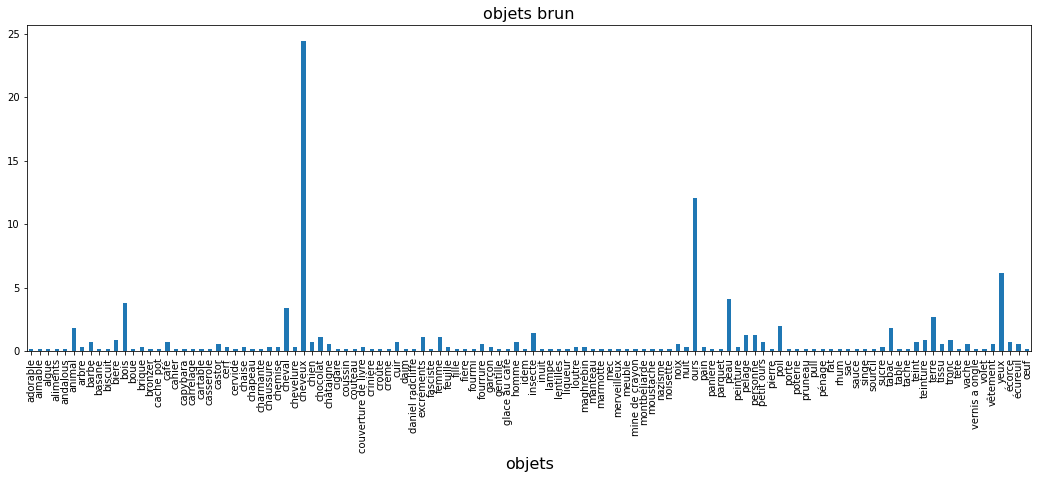

In [49]:
dep = pd.DataFrame(dfGlobal_sort,columns=["colors","percent"])
ax = dep.plot(x="colors",kind = "bar", figsize=(18,6))
ax.set_xlabel("objets", fontsize=16)
ax.set_title("objets brun", fontsize=16)
ax.legend().set_visible(False)  # on supprime la légende

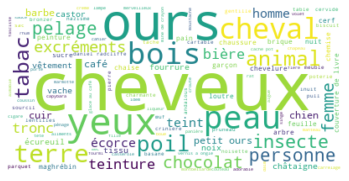

In [59]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tuples = [tuple(x) for x in myDfObjBrun.values]

#generate
tuples = [tuple(x) for x in myDfObjBrun.values]
wordcloud=WordCloud(background_color="white").generate_from_frequencies(dict(tuples))
# show
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# PHRASES ACCEPTABLES ?

Questionnaire : "Est-ce que ces phrases sont acceptables dans la langue française courante ?"
    
A101_01 -> A101_05
...
A105_01 -> A105_05

Réponse -1 (pas acceptable) à 3 (tout à fait acceptable)

# DERIVES acceptables ou non

DE01_01 -> DE01_10

!!! _ et non x

Questionnaire : "Quels termes sont acceptables dans la langue française courante ?"


In [75]:
# dico (pickel) de correspondance entre ref de colonne et dérivés
myDicoDerive=pickle.load(open("myDicoDerive.p","rb"))

myNamesColonnes=list()
for k, v in myDicoDerive.items():
    myNamesColonnes.append(v)
print(myNamesColonnes)

['violacé', 'marronnasse', 'verdelet', 'marronâtre', 'rougeâtre', 'brunâtre', 'griselet', 'mauvasse', 'olivacé', 'bleuâtre']


In [79]:
#créer un sous-dataframe des dérivés
myColDerives=list()

for i in range(1,11):
    if i<10:
        colDerives=str('DE01_0')+str(i)
    else:
        colDerives='DE01_'+str(i)
    myColDerives.append(colDerives)

print(myColDerives)

#Créer un sous tableau ne contenant que ces colonnes
dataDerives = data.loc[:,myColDerives]

#mettre les bons titres :
dataDerives.columns = myNamesColonnes
print(dataDerives)


['DE01_01', 'DE01_02', 'DE01_03', 'DE01_04', 'DE01_05', 'DE01_06', 'DE01_07', 'DE01_08', 'DE01_09', 'DE01_10']
      violacé  marronnasse  verdelet  marronâtre  rougeâtre  brunâtre  \
CASE                                                                    
52        NaN          NaN       NaN         NaN        NaN       NaN   
54        1.0          3.0      -1.0         3.0        1.0       3.0   
55        1.0          2.0      -1.0         3.0        1.0       1.0   
61        2.0          2.0       2.0         2.0        1.0       1.0   
63        NaN          NaN       NaN         NaN        NaN       NaN   
...       ...          ...       ...         ...        ...       ...   
501       1.0          2.0       3.0         1.0        1.0       1.0   
504       NaN          NaN       NaN         NaN        NaN       NaN   
507       2.0          2.0       3.0         1.0        1.0       1.0   
509       NaN          NaN       NaN         NaN        NaN       NaN   
510       1.0

In [119]:
#df_pivot = dataDerives.pivot_table(values = 'Number', columns = 'Year', index = ['FirstName', 'Sex'])
# enlever les lignes où tout est "Na"
dataDerives=dataDerives.dropna(how = 'all')

myCptDerive=[dataDerives[c].value_counts().to_dict() for c in list(myNamesColonnes)]
#print(myCptDerive)

myDfAcceptabilite = pd.DataFrame.from_dict(myCptDerive)
#print(myDfAcceptabilite)
myDfAcceptabilite=myDfAcceptabilite.transpose()
myDfAcceptabilite.columns = myNamesColonnes
myDfAcceptabilite=myDfAcceptabilite.transpose()
print(myDfAcceptabilite)

               1.0   2.0  -1.0    3.0   0.0
violacé       93.0  47.0   9.0    8.0   1.0
marronnasse   32.0  41.0  18.0   66.0   1.0
verdelet       4.0  43.0  41.0   69.0   1.0
marronâtre    33.0  60.0  12.0   53.0   NaN
rougeâtre    139.0  13.0   4.0    1.0   1.0
brunâtre     113.0  30.0   8.0    7.0   NaN
griselet       8.0  33.0  47.0   69.0   1.0
mauvasse       1.0  20.0  25.0  111.0   1.0
olivacé       14.0  52.0  27.0   64.0   1.0
bleuâtre     103.0  34.0  11.0   10.0   NaN


# BROUILLONS

In [ ]:
#valeur relative (METHODE 1)
dfpc = round((myDfObjMarron['number'] / myDfObjMarron['number'].sum()*100),2)
#concatener les tableaux valeur absolue et valeur relative
dfGlobal = pd.concat([myDfObjMarron, dfpc], axis=1)
#nommer la 3eme colonne 'percent'
dfGlobal.set_axis(['colors','number','percent'],axis='columns', inplace=True)
dfGlobal_sort = dfGlobal.sort_values(by = 'colors', ascending = True)
#dfGlobal_sort = dfGlobal.sort_values(by = 'percent', ascending = False)
print(dfGlobal_sort)

In [ ]:
# valeur absolue (1) puis relative (2) (METHODE 2 avec liste de compréhension)
# ... sur un ensemble de colonnes : cf. myColColors
# colonne par colonne
# !!! TODO normaliser les noms de couleurs
# (1) -> 1 colonne = 1 liste
myCptColor_Abs=[dataColors[c].value_counts() for c in list(myColColors)]
#print(myCptColor_Abs)
# (2)
myCptColor_Rel=[dataColors[c].value_counts(normalize=True) for c in list(myColColors)]
#print(myCptColor_Rel)

In [ ]:
# quand l'index n'étaitr pas le panéliste
#dataRepondant = data['CASE']
#dataRepColors= pd.concat([dataRepondant,dataColors], axis=1)
